# Deep Belief Networks

In [182]:
import torch
import torch.nn as nn

from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import transforms

import matplotlib.pyplot as plt

In [183]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [184]:
# Define a single layer of the Deep Belief Network (as a Restricted Boltzmann Machine)
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

    def forward(self, v):
        # Forward pass - calculate the probabilities of hidden units given visible units
        p_h_given_v = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h_given_v

In [185]:
class DBN(nn.Module):
    def __init__(self, n_vis, hidden_layers, n_out):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList(
            [
                RBM(
                    n_vis if i == 0 else hidden_layers[i-1],
                    h
                )
                for i, h in enumerate(hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(hidden_layers[-1], n_out)

    def forward(self, v):
        v = v.view(v.size(0), -1)  # Flatten the input
        for rbm in self.rbms:
            v = rbm(v)
        v = self.output_layer(v)
        return v  # No sigmoid for regression

    def extract_features(self, v):
        with torch.no_grad():
            v = v.view(v.size(0), -1)  # Flatten the input
            for rbm in self.rbms:
                v = rbm(v)
            return v

In [186]:
# Transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [187]:
dbn = DBN(n_vis=32*32, hidden_layers=[500], n_out=10)

In [188]:
def evaluate(dbn, data_loader, device, loss_function):
    dbn.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = dbn(data)
            loss = loss_function(outputs, targets)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


In [189]:
def train_and_plot(dbn, train_loader, test_loader, epochs, learning_rate, device):
    dbn.to(device)
    optimizer = torch.optim.Adam(dbn.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Lists for storing losses
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        dbn.train()
        total_train_loss = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = dbn(data)
            loss = loss_function(output, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        avg_test_loss, _ = evaluate(dbn, test_loader, device, loss_function)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}')

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/40, Train Loss: 2.1427, Test Loss: 2.0772
Epoch 2/40, Train Loss: 2.0493, Test Loss: 2.0337
Epoch 3/40, Train Loss: 2.0164, Test Loss: 2.0138
Epoch 4/40, Train Loss: 1.9938, Test Loss: 1.9904
Epoch 5/40, Train Loss: 1.9730, Test Loss: 1.9716
Epoch 6/40, Train Loss: 1.9533, Test Loss: 1.9537
Epoch 7/40, Train Loss: 1.9347, Test Loss: 1.9350
Epoch 8/40, Train Loss: 1.9167, Test Loss: 1.9230
Epoch 9/40, Train Loss: 1.9009, Test Loss: 1.9052
Epoch 10/40, Train Loss: 1.8853, Test Loss: 1.8918
Epoch 11/40, Train Loss: 1.8700, Test Loss: 1.8754
Epoch 12/40, Train Loss: 1.8566, Test Loss: 1.8635
Epoch 13/40, Train Loss: 1.8445, Test Loss: 1.8541
Epoch 14/40, Train Loss: 1.8317, Test Loss: 1.8461
Epoch 15/40, Train Loss: 1.8214, Test Loss: 1.8359
Epoch 16/40, Train Loss: 1.8120, Test Loss: 1.8255
Epoch 17/40, Train Loss: 1.8021, Test Loss: 1.8216
Epoch 18/40, Train Loss: 1.7928, Test Loss: 1.8074
Epoch 19/40, Train Loss: 1.7848, Test Loss: 1.7998
Epoch 20/40, Train Loss: 1.7762, Test Lo

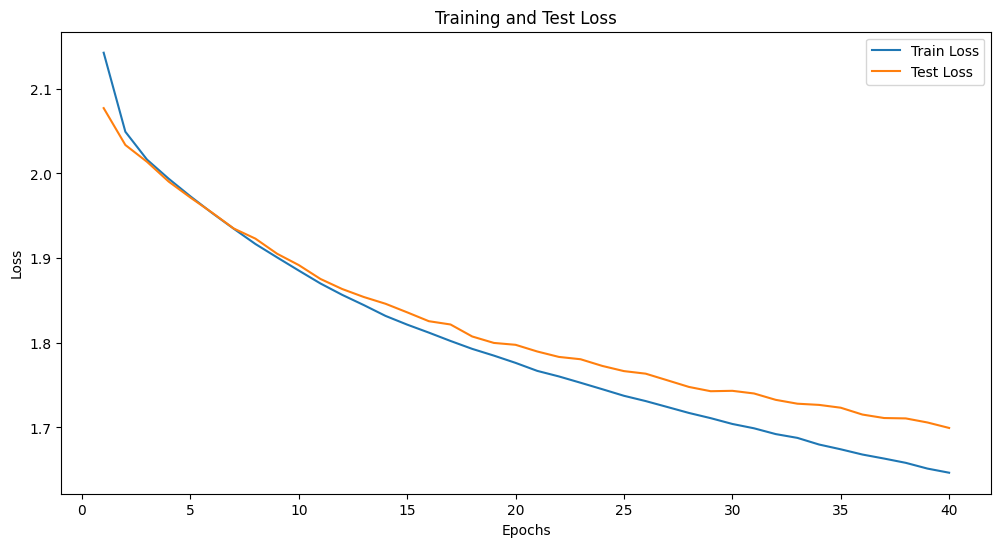

In [190]:
train_and_plot(dbn, train_loader, test_loader, epochs=40, learning_rate=1e-4, device=device)

In [191]:
def test(dbn, test_loader, device):
    dbn.to(device)
    dbn.eval()
    test_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            output = dbn(data)
            test_loss += nn.CrossEntropyLoss()(output, targets).item()

    test_loss /= len(test_loader)
    print(f'Mean test loss: {test_loss}')

In [192]:
test(dbn, test_loader, device)

Mean test loss: 1.6993368469226133


In [193]:
def visualize_features(dbn):
    with torch.no_grad():
        weights = dbn.rbms[0].W.cpu()  # Assuming the first RBM's weights capture primary features

    # Plot some of the weights
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axs.flat):
        ax.imshow(weights[i].view(32, 32), cmap='gray')
        ax.axis('off')

    plt.show()

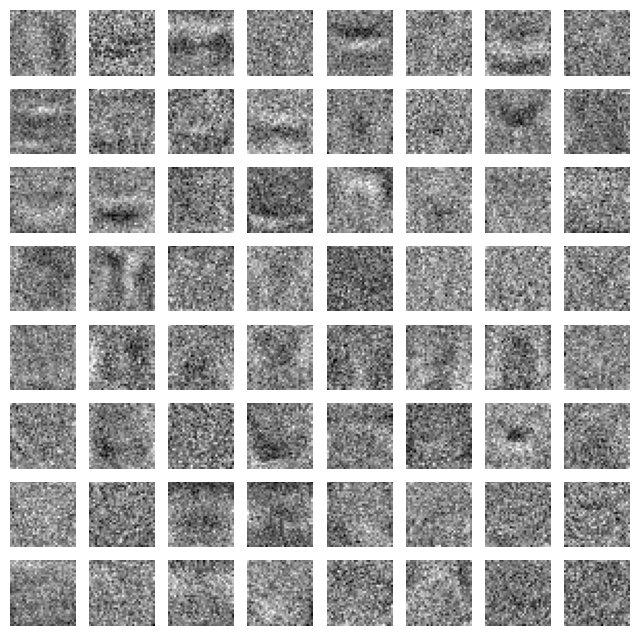

In [194]:
visualize_features(dbn)

In [195]:
import numpy as np

def extract_features(model, data_loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            feature = model.extract_features(data).cpu().numpy()
            features.append(feature)
            labels.append(target.numpy())
    return np.concatenate(features), np.concatenate(labels)

# Example usage
X_train, y_train = extract_features(dbn, train_loader, device)
X_test, y_test = extract_features(dbn, test_loader, device)


In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Since we're using a simple model, let's reduce the dimensionality of the features
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  # Example dimensionality reduction
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))

Accuracy on test set: 0.3908


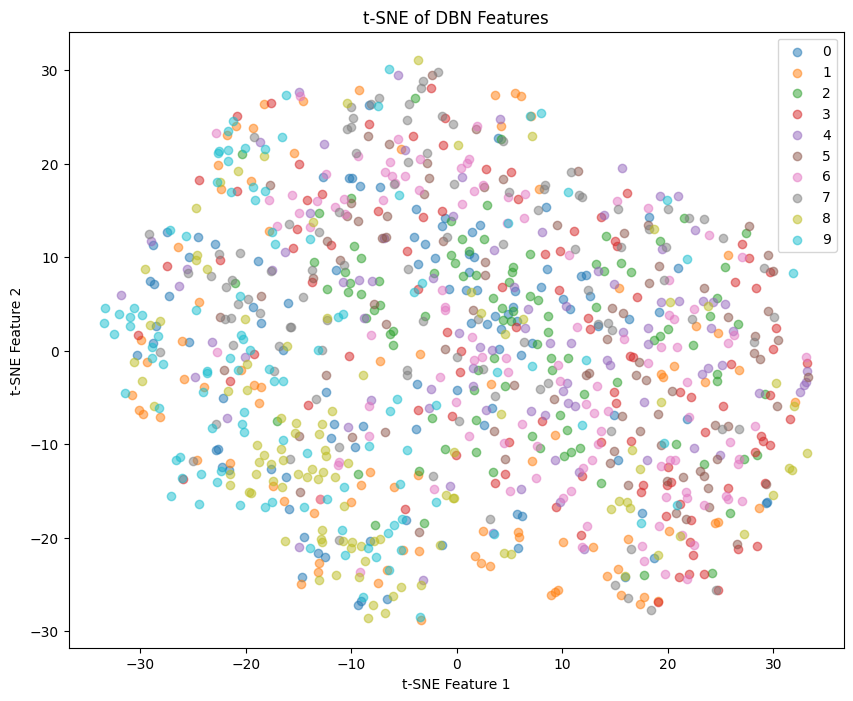

In [197]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2).fit_transform(X_test_pca[:1000])  # t-SNE on a subset for speed

plt.figure(figsize=(10, 8))
for i in range(10):
    indices = y_test[:1000] == i
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=str(i), alpha=0.5)
plt.legend()
plt.title("t-SNE of DBN Features")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()